Imports are held here:

In [1]:
#basic data analysis
import numpy as np
import pandas as pd

#visualizations
import matplotlib.pyplot as plt
import seaborn as sns

#other
import scipy.stats as stats

#datat preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

#model
from sklearn.tree import DecisionTreeClassifier

#evaluation metrics
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score #might not need confusion matrix

# Clean Data 

In [2]:
#import the dataset
student_health = pd.read_csv('student_health_data.csv')


# drop student id
student_health = student_health.drop(columns=["Student_ID"])

#convert object variables to categorical variables
for col in student_health.select_dtypes(include = ['object']).columns:
    student_health[col] = student_health[col].astype('category')

In [3]:
#remove outliers

#define function to identify outliers via IQR
def identify_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

#create dataframe to store outliers
outliers_df = pd.DataFrame()

#apply function to numerical variables
#list of numerical variables
numerical_var = ['Age', 'Heart_Rate', 'Blood_Pressure_Systolic', 'Blood_Pressure_Diastolic',
                 'Stress_Level_Biosensor', 'Stress_Level_Self_Report', 'Study_Hours', 'Project_Hours']

#iterate over variables
for var in numerical_var:
    outliers = identify_outliers(student_health, var)
    #concatenate outliers to outlier dataframe
    outliers_df = pd.concat([outliers_df, outliers])

#drop duplicate rows since some rows may be outliers in multiple columns
outliers_df = outliers_df.drop_duplicates()

#get outlier indices
outlier_indices = outliers_df.index

#drop rows in dataset with outlier indices
cleaned_df = student_health.drop(outlier_indices)

# Getting Ready to Model

#### Split the data

First we separate the our features and target. We'll make a feature matrix and a target vector.

In [4]:
#define feature matrix and target vector
X = cleaned_df.drop(columns = ["Health_Risk_Level"])
y = cleaned_df["Health_Risk_Level"]

In [5]:
#check sizes
print(f'cleaned_df size: {cleaned_df.shape}')
print(f'feature matrix size: {X.shape}')
print(f'target vector size: {y.shape}')

cleaned_df size: (979, 13)
feature matrix size: (979, 12)
target vector size: (979,)


In [6]:
X.head()

,Age,Gender,Heart_Rate,Blood_Pressure_Systolic,Blood_Pressure_Diastolic,Stress_Level_Biosensor,Stress_Level_Self_Report,Physical_Activity,Sleep_Quality,Mood,Study_Hours,Project_Hours
0,24,M,50.663217,122.173015,84.419860,3.137350,9.028669,High,Moderate,Happy,34.520973,16.800956
1,21,F,57.926042,110.778407,75.696145,3.699078,5.819697,Moderate,Good,Stressed,16.763846,15.791154
2,22,M,59.294219,109.375673,83.803814,6.785156,5.892360,Low,Moderate,Happy,44.203798,25.678437
3,24,M,76.826232,125.142227,78.091587,6.408509,6.884001,High,Poor,Happy,21.776645,20.808391
4,20,M,68.342769,107.515592,80.674937,7.264719,4.483450,Moderate,Poor,Happy,8.964999,15.194045


Next step is to split the data into a training set (80%), and validation set for hyperparameter tuning (10%) and a test set for a final model performance (10%)

In [7]:
#split data into a training set and a temp set
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 12)

#split the temp set into a validation set and final test set
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, stratify = y_temp, random_state = 12)

Now to ensure that that the split occurred as desired. First we check the sizes of our feature sets

In [8]:
#check number of instances in each split
print(f"Training set size: {X_train.shape[0]}") #X_train.shape[0] gives the number of rows in the trainin set
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 783
Validation set size: 98
Test set size: 98


In [9]:
print(783/979)
print(98/979)

0.7997957099080695
0.10010214504596528


Now to ensure that each target variable has the same distribution.

In [10]:
#print class distribution as percent
print("Class distribution in Training Set:") #training set
print(y_train.value_counts(normalize=True))  #normalized (percentages)

print("\nClass distribution in Validation Set:") #validation set
print(y_val.value_counts(normalize=True))

print("\nClass distribution in Test Set:") #test set
print(y_test.value_counts(normalize=True))

Class distribution in Training Set:
Moderate    0.670498
Low         0.190294
High        0.139208
Name: Health_Risk_Level, dtype: float64

Class distribution in Validation Set:
Moderate    0.663265
Low         0.193878
High        0.142857
Name: Health_Risk_Level, dtype: float64

Class distribution in Test Set:
Moderate    0.673469
Low         0.183673
High        0.142857
Name: Health_Risk_Level, dtype: float64


As we can see, the data has been successfully split!

#### Preprocess the data

Now that the data has been split, let's go ahead and preprocess it. We begin by encoding the categorical data.
- It should be noted that tree-based models don't require as much preprocessing, but to ensure consistency across different models (tree-based, KNN, SVM), it's simpler to preprocess the data once and use the preprocessed data for all models.
- LabelEncoder converts each category into a unique integer.
- pd.get_dummies is used for one-hot encoding
- Aligning ensures all datasets have the same features.

In [11]:
#encode categorical features - uses one-hot encoding
X_train_encode = pd.get_dummies(X_train)
X_val_encode = pd.get_dummies(X_val)
X_test_encode = pd.get_dummies(X_test)

#align validation and test sets with training set - ensures same columns
X_val_encode = X_val_encode.reindex(columns = X_train_encode.columns, fill_value = 0)
X_test_encode = X_test_encode.reindex(columns = X_train_encode.columns, fill_value = 0)

#initialize and fit scaler on training set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encode)

#transform validation and test data
X_val_scaled = scaler.transform(X_val_encode)
X_test_scaled = scaler.transform(X_test_encode)

#manually set class order
label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(["Low", "Moderate", "High"])  #custom order

#encode labels
y_train_encode = label_encoder.transform(y_train)
y_val_encode = label_encoder.transform(y_val)
y_test_encode = label_encoder.transform(y_test)

#rename matrices and vectors for ease of use
X_train2 = X_train_scaled
X_val2 = X_val_scaled
X_test2 = X_test_scaled

y_train2 = y_train_encode
y_val2 = y_val_encode
y_test2 = y_test_encode

In [12]:
#display mapping of original labels to encoded values
label_mapping = dict(enumerate(label_encoder.classes_))
print("Label Encoding Mapping:", label_mapping)

Label Encoding Mapping: {0: 'Low', 1: 'Moderate', 2: 'High'}


Now that we have our data preprocess, it's time to begin the modeling process.

# KNN Model Building

In [13]:
#libraries 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.inspection import permutation_importance
from matplotlib.colors import ListedColormap
from sklearn.feature_selection import RFE

## Initial KNN Model

In [14]:
# Initial KNN Model 
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train2, y_train2)
y_pred_knn = knn.predict(X_val2)
y_pred_knn

# Evaluate initial model
knn_acc = accuracy_score(y_val2, y_pred_knn)
knn_f1 = f1_score(y_val2, y_pred_knn, average='weighted')
knn_precision = precision_score(y_val2, y_pred_knn, average='weighted')
knn_recall = recall_score(y_val2, y_pred_knn, average='weighted')
confusion_crosstab = pd.crosstab(y_val2, y_pred_knn, rownames = ['Actual'], colnames = ['Predicted'])

# Print Accuracy Metrics
print(f'Validation Accuracy: {knn_acc:.2f}')
print(f'Weighted F1-Score: {knn_f1:.2f}')
print(f'Weighted Precision: {knn_precision:.2f}')
print(f'Weighted Recall: {knn_recall:.2f}')
print('Confusion Matrix:')
print(confusion_crosstab)

Validation Accuracy: 0.68
Weighted F1-Score: 0.68
Weighted Precision: 0.72
Weighted Recall: 0.68
Confusion Matrix:
Predicted   0   1  2
Actual              
0           8  11  0
1          12  53  0
2           2   6  6


**Initial Analysis:**
Initial Models prove to be moderately effective at classification with accuracy around 68%. We will fine tune this model in hopes of increasing these results and reducing error. 

### Parameter Exploration and Tuning

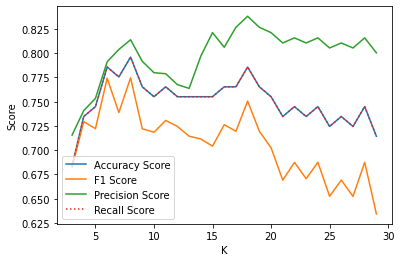

In [15]:
# Testing Number of Neighbors 

acc = {}
f1 = {}
prec = {}
recall = {}
k_levels = list(range(3, 30))

for k in k_levels:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train2, y_train2)
    y_pred = knn.predict(X_val2)
    acc[k] = accuracy_score(y_val2, y_pred)
    f1[k] = f1_score(y_val2, y_pred,  average='weighted')
    prec[k] = precision_score(y_val2, y_pred, average='weighted')
    recall[k] = recall_score(y_val2, y_pred, average='weighted')
    
ACC = list(acc.values())
F1 = list(f1.values())
PREC = list(prec.values())
RECALL = list(recall.values())

# Plotting K v/s accuracy graph
plt.plot(k_levels, ACC, label = 'Accuracy Score',)
plt.plot(k_levels, F1, label = 'F1 Score')
plt.plot(k_levels, PREC, label = 'Precision Score')
plt.plot(k_levels, RECALL, label = 'Recall Score',  linestyle='dotted')
plt.xlabel('K')
plt.ylabel('Score')
plt.legend(loc = 'lower left')
plt.show()

**Initial Score Analysis**
Exploring the impact on the number of neighbors was the first step taken to fine tune the initial KNN model. This helps inform which values are best to be included in the gridsearch.It seems we will explore k values between 5 and 20 for the next step in our model tuning. This range of values seems to have the lower chance of overfitting than values outside of this range.  Something interesting happened in that our accuracy scores were identical to the recall scores. This shows that the weighting of the classes within the recall impacts the misclassification errors to be distributed evenly by the class frequency.

In [16]:
# Grid Search for Best Parameters
param_grid = {
    'n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2]
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train2, y_train2)

# Print Best Parameters and Score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

Best Parameters: {'metric': 'euclidean', 'n_neighbors': 12, 'p': 1, 'weights': 'uniform'}
Best Cross-Validation Score: 0.7599297729870977


In [17]:
# Cross Validation with Best Parameters 
best_knn = grid_search.best_estimator_
best_knn.fit(X_train2, y_train2)
cv_scores = cross_val_score(best_knn, X_train2, y_train2, cv=5)

print("Cross-validation scores:", cv_scores)
print(f'Mean CV score: {np.mean(cv_scores):.3f}')

Cross-validation scores: [0.73248408 0.77707006 0.74522293 0.75641026 0.78846154]
Mean CV score: 0.760


### Testing Best Model

In [18]:
# Validation Set 

y_pred_knn = best_knn.predict(X_val2)
y_pred_knn

# Evaluate best model on validation set 
knn_acc_val = accuracy_score(y_val2, y_pred_knn)
knn_f1_val = f1_score(y_val2, y_pred_knn, average='weighted')
knn_precision_val = precision_score(y_val2, y_pred_knn, average='weighted')
knn_recall_val = recall_score(y_val2, y_pred_knn, average='weighted')
confusion_crosstab_val = pd.crosstab(y_val2, y_pred_knn, rownames = ['Actual'], colnames = ['Predicted'])

# Print Accuracy Metrics
print(f'Validation Accuracy: {knn_acc_val:.2f}')
print(f'Weighted F1-Score: {knn_f1_val:.2f}')
print(f'Weighted Precision: {knn_precision_val:.2f}')
print(f'Weighted Recall: {knn_recall_val:.2f}')
print('Confusion Matrix:')
print(confusion_crosstab_val)

Validation Accuracy: 0.76
Weighted F1-Score: 0.72
Weighted Precision: 0.77
Weighted Recall: 0.76
Confusion Matrix:
Predicted  0   1  2
Actual             
0          6  13  0
1          3  62  0
2          0   8  6


In [19]:
# Test Set 
y_pred_knn = best_knn.predict(X_test2)
y_pred_knn

# Evaluate best model on test set 
knn_acc_test = accuracy_score(y_test2, y_pred_knn)
knn_f1_test = f1_score(y_test2, y_pred_knn, average='weighted')
knn_precision_test = precision_score(y_test2, y_pred_knn, average='weighted')
knn_recall_test = recall_score(y_test2, y_pred_knn, average='weighted')
confusion_crosstab_test = pd.crosstab(y_test2, y_pred_knn, rownames = ['Actual'], colnames = ['Predicted'])

# Print Accuracy Metrics
print(f'Test Accuracy: {knn_acc_test:.2f}')
print(f'Weighted F1-Score: {knn_f1_test:.2f}')
print(f'Weighted Precision: {knn_precision_test:.2f}')
print(f'Weighted Recall: {knn_recall_test:.2f}')
print('Confusion Matrix:')
print(confusion_crosstab_test)

Test Accuracy: 0.74
Weighted F1-Score: 0.70
Weighted Precision: 0.76
Weighted Recall: 0.74
Confusion Matrix:
Predicted  0   1  2
Actual             
0          4  14  0
1          2  64  0
2          0   9  5


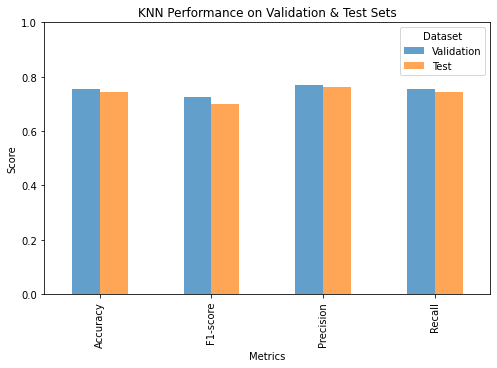

In [20]:
# Bar graph of scores 

knn_scores = pd.DataFrame()
knn_scores['Validation'] = [knn_acc_val, knn_f1_val, knn_precision_val, knn_recall_val]
knn_scores['Test'] = [knn_acc_test, knn_f1_test, knn_precision_test, knn_recall_test]


# Plot the DataFrame as a bar chart
knn_scores.plot(kind='bar', figsize=(8, 5), alpha=0.7)

# Formatting
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('KNN Performance on Validation & Test Sets')
plt.xticks(ticks=[0, 1, 2, 3], labels=['Accuracy', 'F1-score', 'Precision', 'Recall'])
plt.ylim(0, 1) 
plt.legend(title='Dataset')

# Show the plot
plt.show()

When comparing the validation and test set accuracies, we do not see much drastic changes and therefore this means our model is not overfitting too much to the training set and is performing well on both the held out sets. 

## Feature Importance 

In [21]:
# Determine Feature Importance

perm_importance = permutation_importance(best_knn, X_train2, y_train2, scoring='accuracy')

feature_importances = perm_importance.importances_mean
features = X_train_encode.columns

importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)
print("\nPermutation Feature Importance:\n", importance_df)


Permutation Feature Importance:
                        Feature  Importance
5     Stress_Level_Self_Report    0.066411
4       Stress_Level_Biosensor    0.062324
10      Physical_Activity_High    0.034738
15          Sleep_Quality_Poor    0.027331
13          Sleep_Quality_Good    0.015581
3     Blood_Pressure_Diastolic    0.007918
14      Sleep_Quality_Moderate    0.005364
1                   Heart_Rate    0.004342
12  Physical_Activity_Moderate    0.003065
0                          Age    0.002043
9                     Gender_M    0.001533
8                     Gender_F    0.001533
18               Mood_Stressed    0.001277
11       Physical_Activity_Low    0.000766
17                Mood_Neutral   -0.001788
6                  Study_Hours   -0.002299
2      Blood_Pressure_Systolic   -0.004853
16                  Mood_Happy   -0.006130
7                Project_Hours   -0.006641


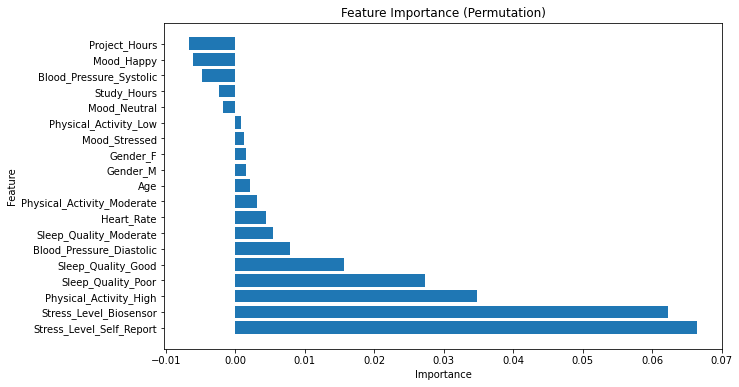

In [22]:
# Visualize Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.title("Feature Importance (Permutation)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

#### Analysis:

Permutation Importance method assesses the impact on accuracy score when this variable is removed during a particular permutation.

Most impacful features: Stress_Level_Biosensor, Stress_Level_Self_Report, Physical_Activity_High, Sleep_Quality_Poor. These are the same important features as those found through the Trees exploration. 

## Rerun KNN With Top 4 Features 

In [23]:
important_features = ['Stress_Level_Self_Report', 'Stress_Level_Biosensor', 'Sleep_Quality_Poor', 'Physical_Activity_High']

#create subsets
X_train_subset = X_train_encode[important_features]
X_val_subset = X_val_encode[important_features]
X_test_subset = X_test_encode[important_features]

#scale subsets - note we created subset from the encoded, so scaling still needs to be done.
scaler = StandardScaler()
X_train_subset_scaled = scaler.fit_transform(X_train_subset)
X_val_subset_scaled = scaler.transform(X_val_subset)
X_test_subset_scaled = scaler.transform(X_test_subset)

#check the shapes
print(X_train_subset_scaled.shape, X_val_subset_scaled.shape, X_test_subset_scaled.shape)

#rename for ease of use
X_train3 = X_train_subset_scaled
X_val3 = X_val_subset_scaled
X_test3 = X_test_subset_scaled

(783, 4) (98, 4) (98, 4)


### Initial Model On Top 4 Features

In [24]:
# Initial KNN Model 
pruned_knn = KNeighborsClassifier(n_neighbors = 3)
pruned_knn.fit(X_train3, y_train2)
y_pred_knn = pruned_knn.predict(X_val3)
y_pred_knn

# Evaluate initial model
knn_acc = accuracy_score(y_val2, y_pred_knn)
knn_f1 = f1_score(y_val2, y_pred_knn, average='weighted')
knn_precision = precision_score(y_val2, y_pred_knn, average='weighted')
knn_recall = recall_score(y_val2, y_pred_knn, average='weighted')
confusion_crosstab = pd.crosstab(y_val2, y_pred_knn, rownames = ['Actual'], colnames = ['Predicted'])

# Print Accuracy Metrics
print(f'Validation Accuracy: {knn_acc:.2f}')
print(f'Weighted F1-Score: {knn_f1:.2f}')
print(f'Weighted Precision: {knn_precision:.2f}')
print(f'Weighted Recall: {knn_recall:.2f}')
print('Confusion Matrix:')
print(confusion_crosstab)

Validation Accuracy: 0.93
Weighted F1-Score: 0.93
Weighted Precision: 0.93
Weighted Recall: 0.93
Confusion Matrix:
Predicted   0   1   2
Actual               
0          17   2   0
1           0  62   3
2           0   2  12


### Parameter Tuning On Top 4 Features

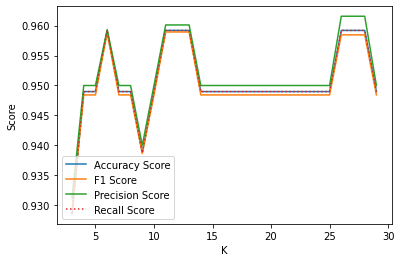

In [25]:
# Testing Number of Neighbors 

acc = {}
f1 = {}
prec = {}
recall = {}
k_levels = list(range(3, 30))

for k in k_levels:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train3, y_train2)
    y_pred = knn.predict(X_val3)
    acc[k] = accuracy_score(y_val2, y_pred)
    f1[k] = f1_score(y_val2, y_pred,  average='weighted')
    prec[k] = precision_score(y_val2, y_pred, average='weighted')
    recall[k] = recall_score(y_val2, y_pred, average='weighted')
    
ACC = list(acc.values())
F1 = list(f1.values())
PREC = list(prec.values())
RECALL = list(recall.values())

# Plotting K v/s accuracy graph
plt.plot(k_levels, ACC, label = 'Accuracy Score',)
plt.plot(k_levels, F1, label = 'F1 Score')
plt.plot(k_levels, PREC, label = 'Precision Score')
plt.plot(k_levels, RECALL, label = 'Recall Score',  linestyle='dotted')
plt.xlabel('K')
plt.ylabel('Score')
plt.legend(loc = 'lower left')
plt.show()

In [26]:
# Grid Search for Best Parameters
param_grid = {
    'n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2]
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train3, y_train2)

# Print Best Parameters and Score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

Best Parameters: {'metric': 'manhattan', 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Best Cross-Validation Score: 0.9667646578474605


In [27]:
# Cross Validation with Best Parameters 
best_knn = grid_search.best_estimator_
best_knn.fit(X_train3, y_train2)
cv_scores = cross_val_score(best_knn, X_train3, y_train2, cv=5)

print("Cross-validation scores:", cv_scores)
print("Mean CV score:", np.mean(cv_scores))

Cross-validation scores: [0.98089172 0.95541401 0.98726115 0.94871795 0.96153846]
Mean CV score: 0.9667646578474605


### Testing Top 4 Features Model

In [28]:
# Validation Set 

y_pred_knn = best_knn.predict(X_val3)
y_pred_knn

# Evaluate best model on validation set 
knn_acc = accuracy_score(y_val2, y_pred_knn)
knn_f1 = f1_score(y_val2, y_pred_knn, average='weighted')
knn_precision = precision_score(y_val2, y_pred_knn, average='weighted')
knn_recall = recall_score(y_val2, y_pred_knn, average='weighted')
confusion_crosstab = pd.crosstab(y_val2, y_pred_knn, rownames = ['Actual'], colnames = ['Predicted'])

# Print Accuracy Metrics
print(f'Validation Accuracy: {knn_acc:.2f}')
print(f'Weighted F1-Score: {knn_f1:.2f}')
print(f'Weighted Precision: {knn_precision:.2f}')
print(f'Weighted Recall: {knn_recall:.2f}')
print('Confusion Matrix:')
print(confusion_crosstab)

Validation Accuracy: 0.95
Weighted F1-Score: 0.95
Weighted Precision: 0.95
Weighted Recall: 0.95
Confusion Matrix:
Predicted   0   1   2
Actual               
0          17   2   0
1           0  64   1
2           0   2  12


In [29]:
# Test Set 
y_pred_knn = best_knn.predict(X_test3)
y_pred_knn

# Evaluate best model on test set 
knn_acc = accuracy_score(y_test2, y_pred_knn)
knn_f1 = f1_score(y_test2, y_pred_knn, average='weighted')
knn_precision = precision_score(y_test2, y_pred_knn, average='weighted')
knn_recall = recall_score(y_test2, y_pred_knn, average='weighted')
confusion_crosstab = pd.crosstab(y_test2, y_pred_knn, rownames = ['Actual'], colnames = ['Predicted'])

# Print Accuracy Metrics
print(f'Test Accuracy: {knn_acc:.2f}')
print(f'Weighted F1-Score: {knn_f1:.2f}')
print(f'Weighted Precision: {knn_precision:.2f}')
print(f'Weighted Recall: {knn_recall:.2f}')
print('Confusion Matrix:')
print(confusion_crosstab)

Test Accuracy: 0.96
Weighted F1-Score: 0.96
Weighted Precision: 0.96
Weighted Recall: 0.96
Confusion Matrix:
Predicted   0   1   2
Actual               
0          16   2   0
1           1  65   0
2           0   1  13


**Prune Model Accuracy:**

When focusing strictly on the top 4 impactful features of the dataset, we are able to increase our accuracy from values in the 70s to values  closer to 0.95 and 0.96. This is an impressive increase and the test on both the validation and test sets indicates that we likely aren't seeing a singularly remarkable increase, but a generalizable model to multiple test sets. 

### Feature Importance of Top 4 Features

In [30]:
# Determine Feature Importance

perm_importance = permutation_importance(best_knn, X_train3, y_train2, scoring='accuracy')

feature_importances = perm_importance.importances_mean
features = X_train_subset.columns

importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)
print("\nPermutation Feature Importance:\n", importance_df)


Permutation Feature Importance:
                     Feature  Importance
0  Stress_Level_Self_Report    0.347637
1    Stress_Level_Biosensor    0.345594
3    Physical_Activity_High    0.069987
2        Sleep_Quality_Poor    0.062324


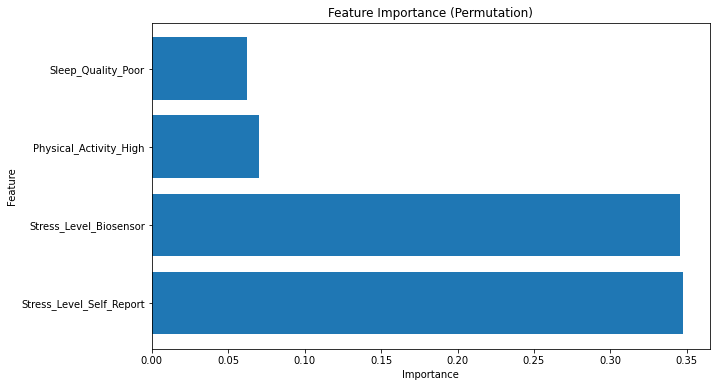

In [31]:
# Visualize Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.title("Feature Importance (Permutation)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

Removing other features also increased the importance impact of these features. This makes sense and seems somewhat proportional to the size of impact these features had when amongst the other variables with the Stress_Level_Biosensor and Stress_Level_Self_Report having the greatest impact and the attributes of High Physical Actviity and Poor Sleep Quality having much less but still some impact on the accurcacy metrics. 

Future Notes:
Education around Stress Reduction techniques,
High Physical Activity has greater impact on the score than Low or Moderate Physical Activity. 
Poor Sleep Quality has great impact on the score than Good or Great Sleep Quality. 